In [1]:
import itertools as itt
import math
from collections import Counter, defaultdict

import bioregistry
import bioversions
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pyobo
from disease import CONFIGURATION, MODULE
from IPython.display import SVG
from tqdm.auto import tqdm

import semra
import semra.api
from semra.api import get_index, to_multidigraph
from semra.io import from_pickle, from_sssom

/Users/cthoyt/.virtualenvs/indra/lib/python3.11/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


## Summarize the Resources

In [2]:
terms = {prefix: pyobo.get_id_name_mapping(prefix) for prefix in tqdm(CONFIGURATION.priority)}

  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
no_versions = {"omim.ps", "icd10", "icd9", "icd11", "icd10cm", "icd10pcs", "icd9cm", "icdo", "gard", 'omim'}
summary_rows = [
    (
        prefix,
        bioregistry.get_license(prefix),
        bioversions.get_version(prefix) if prefix not in no_versions else None,
        len(terms.get(prefix, [])),
    )
    for prefix in CONFIGURATION.priority
]
summary_df = pd.DataFrame(summary_rows, columns=["prefix", "license", "version", "terms"])
summary_df

,prefix,license,version,terms
0,doid,CC0-1.0,2024-02-28,11511
1,mondo,CC-BY-4.0,2024-03-04,24099
2,efo,Apache-2.0,3.64.0,16410
3,mesh,CC0-1.0,2024,354069
4,gard,None,None,0


## Summarize the Mappings

In [4]:
mappings = from_pickle(MODULE.join(name="processed.pkl"))
processed_n = len(mappings)
processed_n

154767

In [5]:
# Remove many-to-many mappings since it overinflates
# mappings = semra.api.filter_many_to_many(mappings, progress=False)
# filtered_n = len(mappings)
# filtered_n

# TODO filter out many-to-many mappings before starting -
# using the typical function doesn't work since there is

In [6]:
index = get_index(mappings, progress=False)

In [7]:
directed = defaultdict(set)
for s, p, o in index:
    if p != semra.EXACT_MATCH:
        continue
    directed[s.prefix, o.prefix].add(s.identifier)
    directed[o.prefix, s.prefix].add(o.identifier)

### Asymmetric Summarization

The following summary looks for each ordered pair of resources, what percentage of each resources' terms are mapped to the other resource. Because each resource is a different size, this is an asymmetric measurement.

The way to read this table is the horizontal index corresponds to the source prefix and the columns correspond to the target prefix. This means in the row with label "efo" and column with label "mesh" that has 14% means that 14% of EFO can be mapped to MeSH.

In [8]:
def _df(xx, default=1.0):
    rows = [
        [default if p1 == p2 else xx.get((p1, p2), None) for p2 in CONFIGURATION.priority]
        for p1 in CONFIGURATION.priority
    ]
    df = pd.DataFrame(rows, columns=CONFIGURATION.priority, index=CONFIGURATION.priority)
    df.index.name = "source_prefix"
    df.columns.name = "target_prefix"
    return df

In [9]:
asymmetric_counts = {}
for (l, r), l_entities in directed.items():
    l_terms = terms.get(l)
    if l_terms:
        count = len(l_entities.intersection(l_terms))
    else:
        count = len(l_entities)
    asymmetric_counts[l, r] = count

asymmetric_counts_summary_df = _df(asymmetric_counts, default=0).fillna(0).astype(int)
asymmetric_counts_summary_df

target_prefix,doid,mondo,efo,mesh,gard
source_prefix,,,,,
doid,0,11161,2326,2642,30
mondo,11234,0,3230,8305,6
efo,2391,3095,0,2128,2
mesh,2810,8332,2193,0,20
gard,30,6,2,21,0


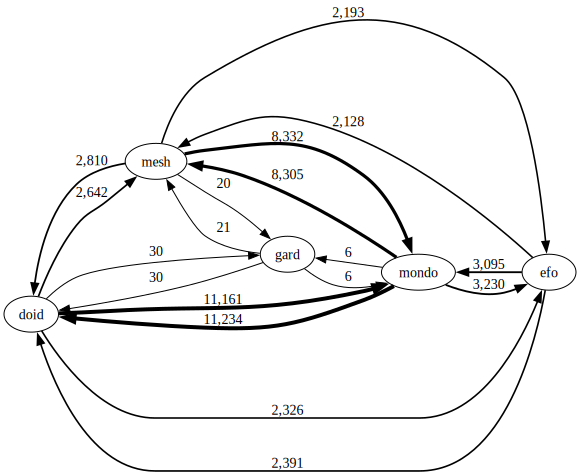

In [10]:
def _graph_svg(counter, scaling_factor: float = 3.0, fmt=",", cls=nx.DiGraph, cutoff=0.0):
    graph = cls()
    for (s, t), count in counter.items():
        if not count:
            continue
        if count <= cutoff:
            continue
        graph.add_edge(s, t, label=f"{count:{fmt}}")

    agraph = nx.nx_agraph.to_agraph(graph)
    agraph.graph_attr["rankdir"] = "LR"

    values = [v for v in counter.values() if v is not None and v > 0]
    bottom, top = min(values), max(values)
    rr = top - bottom

    for edge, weight in counter.items():
        if not weight:
            continue
        x = 1 + scaling_factor * (weight - bottom) / rr
        if agraph.has_edge(*edge):
            agraph.get_edge(*edge).attr["penwidth"] = x
    return agraph.draw(prog="dot", format="svg")


SVG(_graph_svg(asymmetric_counts, cutoff=5))

In [11]:
asymmetric = {}
for (l, r), count in asymmetric_counts.items():
    denominator = len(terms.get(l, []))
    asymmetric[l, r] = count / denominator if denominator > 0 else None

asymmetric_summary_df = _df(asymmetric)
(asymmetric_summary_df * 100).round(2)

target_prefix,doid,mondo,efo,mesh,gard
source_prefix,,,,,
doid,100.00,96.96,20.21,22.95,0.26
mondo,46.62,100.00,13.40,34.46,0.02
efo,14.57,18.86,100.00,12.97,0.01
mesh,0.79,2.35,0.62,100.00,0.01
gard,NaN,NaN,NaN,NaN,100.00


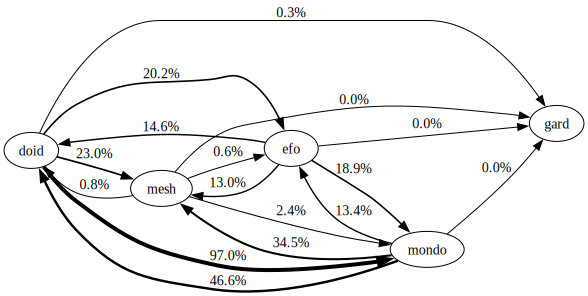

In [12]:
SVG(_graph_svg(asymmetric, fmt=".1%"))

### Symmetric Summarization

In [13]:
symmetric_counts = {}
for l, r in directed:
    left = directed[l, r]
    if left_terms := terms.get(l, []):
        left.intersection_update(left_terms)
    right = directed[r, l]
    if right_terms := terms.get(r, []):
        right.intersection_update(right_terms)
    symmetric_counts[l, r] = max(len(left), len(right))
_df(symmetric_counts, default=0).fillna(0).astype(int)

target_prefix,doid,mondo,efo,mesh,gard
source_prefix,,,,,
doid,0,11234,2391,2810,30
mondo,11234,0,3230,8332,6
efo,2391,3230,0,2193,2
mesh,2810,8332,2193,0,21
gard,30,6,2,21,0


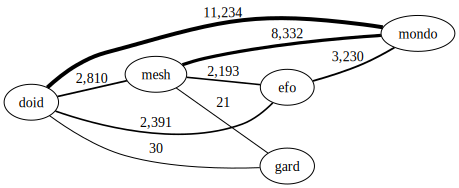

In [14]:
x = _graph_svg(symmetric_counts, cls=nx.Graph, cutoff=20)
with open("disease_graph.svg", "wb") as file:
    file.write(x)
SVG(x)

In [15]:
# intersect with the terms for each to make sure we're not keeping any mappings that are irrelevant

symmetric = {}
for (l, r), count in symmetric_counts.items():
    if terms[r] and terms[l]:
        denom = min(len(terms[r]), len(terms[l]))
    elif terms[r]:
        denom = len(terms[r])
    elif terms[l]:
        denom = len(terms[l])
    else:
        denom = 1
    symmetric[l,r] = count / denom

symmetric_df = _df(symmetric).fillna(0.0)

# clip since there might be some artifacts of mappings to terms that don't exist anymore
(symmetric_df * 100).round(4)

target_prefix,doid,mondo,efo,mesh,gard
source_prefix,,,,,
doid,100.0000,97.5936,20.7714,24.4114,0.2606
mondo,97.5936,100.0000,19.6831,34.5740,0.0249
efo,20.7714,19.6831,100.0000,13.3638,0.0122
mesh,24.4114,34.5740,13.3638,100.0000,0.0059
gard,0.2606,0.0249,0.0122,0.0059,100.0000


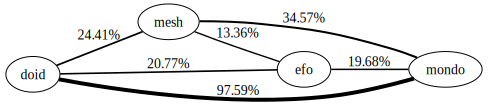

In [16]:
SVG(_graph_svg(symmetric, cls=nx.Graph, fmt=".2%", cutoff=0.01))

# Landscape Coverage

Before, we looked at the overlaps between each resource. Now, we use that information jointly to estimate the number of terms in the landscape itself, and estimate how much of the landscape each resource covers.

TODO!

In [33]:
entities = defaultdict(set)
for mapping in mappings:
    for r in (mapping.s, mapping.o):
        entities[r.prefix].add(r.identifier)

counter = Counter()
graph = to_multidigraph(mappings)
for component in nx.weakly_connected_components(graph):
    prefixes = frozenset(r.prefix for r in component)
    counter[prefixes] += 1

at_least_1_mapping = sum(counter.values())

unique_to_single = defaultdict(set)
for prefix in CONFIGURATION.priority:
    prefix_terms = terms.get(prefix)
    if not prefix_terms:
        continue
    
    prefix_terms = set(prefix_terms)
    mapped_terms = entities[prefix]    
    counter[frozenset([prefix])] = unique_to_single[prefix] = len(prefix_terms - mapped_terms)

only_1_mapping = sum(unique_to_single.values())
total_entity_estimate = sum(counter.values())

print(
    f"This estimates a total of {total_entity_estimate:,} unique entities.\n"
    f"Of these, {at_least_1_mapping:,} ({at_least_1_mapping/total_entity_estimate:.1%}) have at least one mapping.\n"
    f"{only_1_mapping:,} ({only_1_mapping/total_entity_estimate:.1%}) are unique to a single resource.\n\n"
    "This estimate is susceptible to several caveats:\n\n"
    "- Missing mappings inflates this measurement\n"
    "- Generic resources like MeSH contain irrelevant entities that can't be mapped\n"
)

counter

  0%|          | 0.00/155k [00:00<?, ?mapping/s]

This estimates a total of 383,597 unique entities.
Of these, 19,560 (5.1%) have at least one mapping.
364,037 (94.9%) are unique to a single resource.

This estimate is susceptible to several caveats:

- Missing mappings inflates this measurement
- Generic resources like MeSH contain irrelevant entities that can't be mapped



Counter({frozenset({'mesh'}): 345335,
         frozenset({'efo'}): 13148,
         frozenset({'mondo'}): 5230,
         frozenset({'gard', 'mondo'}): 4901,
         frozenset({'doid', 'mondo'}): 3397,
         frozenset({'doid', 'gard', 'mesh', 'mondo'}): 2453,
         frozenset({'doid', 'gard', 'mondo'}): 1855,
         frozenset({'gard', 'mesh', 'mondo'}): 1565,
         frozenset({'mesh', 'mondo'}): 1496,
         frozenset({'doid', 'efo', 'mesh', 'mondo'}): 1097,
         frozenset({'doid', 'efo', 'gard', 'mesh', 'mondo'}): 762,
         frozenset({'doid', 'mesh', 'mondo'}): 721,
         frozenset({'doid', 'efo', 'mondo'}): 364,
         frozenset({'efo', 'mondo'}): 359,
         frozenset({'doid'}): 324,
         frozenset({'efo', 'mesh', 'mondo'}): 164,
         frozenset({'efo', 'mesh'}): 146,
         frozenset({'doid', 'efo', 'gard', 'mondo'}): 112,
         frozenset({'efo', 'gard', 'mondo'}): 85,
         frozenset({'efo', 'gard', 'mesh', 'mondo'}): 53,
         frozenset(

/var/folders/vp/n7_7v49n7dl7ln9bs8r0wbt80000gn/T/ipykernel_30166/773260000.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


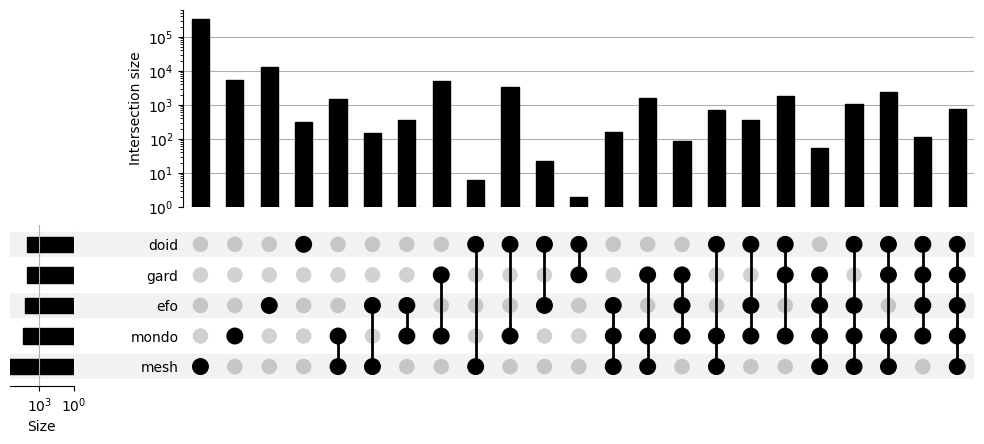

In [27]:
import upsetplot

a, b = zip(*counter.most_common())
example = upsetplot.from_memberships(a, b)

"""Here's what the output from upsetplot.plot looks like:

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}
"""
plot_result = upsetplot.plot(
    example, 
    #show_counts=True,
)
plot_result['intersections'].set_yscale("log")
plot_result['intersections'].set_ylim(
    [1, plot_result['intersections'].get_ylim()[1]]
)
plot_result["totals"].set_xlabel("Size")
mm, _ = plot_result["totals"].get_xlim()
plot_result["totals"].set_xlim([mm, 1])
plot_result["totals"].set_xscale('log') # gets domain error

plt.tight_layout()
plt.show()